In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, datasets, utils
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import copy
import os
from sklearn.model_selection import StratifiedShuffleSplit as SSS

In [87]:
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = 'cpu'
print(device)

cpu


In [88]:
data_transform =transforms.Compose([
    transforms.ToTensor()
])

# load datasets
DATA_PATH = './data/stl-10'

train = datasets.STL10(DATA_PATH, split='train', download=True, transform=data_transform)
test = datasets.STL10(DATA_PATH, split='test', download=True, transform=data_transform)

meanRGB = [np.mean(x.numpy(), axis=(1, 2)) for x, _ in train]
stdRGB = [np.std(x.numpy(), axis=(1, 2)) for x, _ in train]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(227),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
    transforms.Resize(227)
])

train.transform = train_transform
test.transform = test_transform

print(train.data.shape)
print(test.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(5000, 3, 96, 96)
(8000, 3, 96, 96)


/var/folders/81/_1yshp9s2sxb1nghxqpzk7b40000gn/T/ipykernel_55591/3878690303.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  random_idx = int(np.random.randint(0, len(train), 1))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


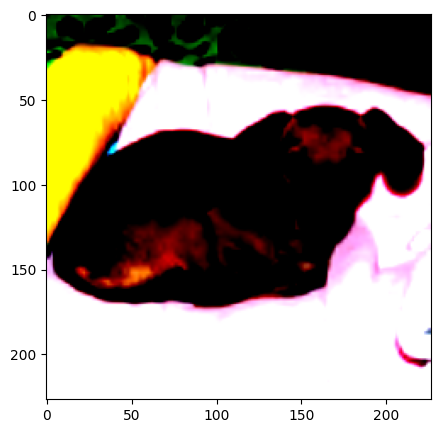

In [89]:
def show_img(img, color=True):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

np.random.seed(0)
torch.manual_seed(0)

random_idx = int(np.random.randint(0, len(train), 1))
img, label = train[random_idx]

plt.figure(figsize=(5, 5))
show_img(img)

In [90]:
sss = SSS(n_splits=1, test_size=0.2, random_state=0)
indices = list(range(len(test)))
y_test = [y for _, y in test]

for test_idx, valid_idx in sss.split(indices, y_test):
    continue

valid = Subset(test, valid_idx)
test = Subset(test, test_idx)

train_loader = DataLoader(train, batch_size=32)
valid_loader = DataLoader(valid, batch_size=32)

In [91]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        # input_size = (batch_size x 3 x 227 x 227)

        self.net = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=(256*6*6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes)
        )

        self.init_weight()


    def init_weight(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d): # if layer==Conv
                nn.init.normal_(layer.weight, mean=0, std=0.01) # then reset weights by N(0, 0.01) and bias=0
                nn.init.constant_(layer.bias, 0)
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)  # 5th, 11th, 13th layers' bias reset as 1

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x
    
model = AlexNet().to(device)
print(next(model.parameters()).device)
model.eval()

cpu


AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): Re

In [92]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.01)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
# StepLR : per steps, multiple gamma to learning_rate
lr_scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [93]:
# calculate accuracy per batch
def get_accuracy(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# calculate loss per batch
def loss_batch(criterion, output, target, optimizer=None):
    loss = criterion(output, target)
    acc = get_accuracy(output, target)
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item(), acc

# calculate performance loss, accuracy per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, optimizer=None):
    running_loss = 0
    running_acc = 0
    len_data = float(len(dataset_dl.dataset))

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        loss_b, acc_b = loss_batch(loss_func, output, yb, optimizer)
        running_loss += loss_b

        if acc_b:
            running_acc += acc_b
        
        if sanity_check: # if sannity_check is True, only one batch is processed
            break

    loss = running_loss / len_data
    acc = running_acc / len_data
    return loss, acc


In [96]:
def train_val(model, params):
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    optimizer = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    loss_history = {
        'train': [],
        'val': []
    }

    acc_history = {
        'train': [],
        'val': []
    }

    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        current_lr = get_lr(optimizer)
        print('Epoch {}/{}, current lr = {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_acc = loss_epoch(model, loss_func, train_dl, sanity_check, optimizer)
        loss_history['train'].append(train_loss)
        acc_history['train'].append(train_acc)

        model.eval()
        with torch.no_grad():
            val_loss, val_acc = loss_epoch(model, loss_func, val_dl, sanity_check)
            loss_history['val'].append(val_loss)
            acc_history['val'].append(val_acc)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step()

        print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f' % (train_loss, val_loss, val_acc*100))
        print('-'*15)

        if epoch % 1 == 0:
            model.load_state_dict(best_model_weights)

    return model, loss_history, acc_history

In [101]:
os.makedirs('./models', exist_ok=True)

params_train = {
    'num_epochs': 10,
    'optimizer': optimizer,
    'loss_func': criterion,
    'train_dl': train_loader,
    'val_dl': valid_loader,
    'sanity_check': False,
    'lr_scheduler': lr_scheduler,
    'path2weights': './models/weights.pt'
}

model, loss_hist, acc_hist = train_val(model, params_train)

Epoch 0/9, current lr = 0.01
Copied best model weights!
train loss: 2.304758, dev loss: 2.302909, accuracy: 10.00
---------------
Epoch 1/9, current lr = 0.01
train loss: 2.304778, dev loss: 2.302915, accuracy: 10.00
---------------
Epoch 2/9, current lr = 0.01
train loss: 2.304786, dev loss: 2.302920, accuracy: 10.00
---------------
Epoch 3/9, current lr = 0.01
train loss: 2.304792, dev loss: 2.302923, accuracy: 10.00
---------------
Epoch 4/9, current lr = 0.01
train loss: 2.304797, dev loss: 2.302926, accuracy: 10.00
---------------
Epoch 5/9, current lr = 0.01
train loss: 2.304801, dev loss: 2.302928, accuracy: 10.00
---------------
Epoch 6/9, current lr = 0.01
train loss: 2.304804, dev loss: 2.302930, accuracy: 10.00
---------------
Epoch 7/9, current lr = 0.01
train loss: 2.304806, dev loss: 2.302931, accuracy: 10.00
---------------
Epoch 8/9, current lr = 0.01
train loss: 2.304808, dev loss: 2.302932, accuracy: 10.00
---------------
Epoch 9/9, current lr = 0.01
train loss: 2.304

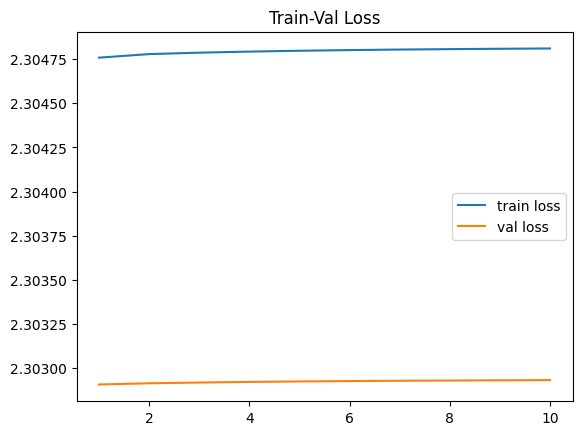

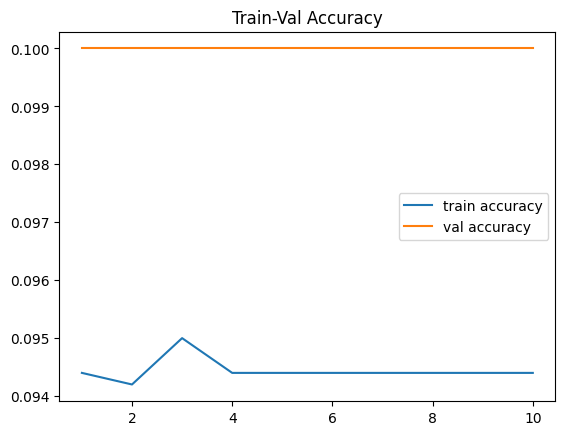

In [102]:
num_epochs = params_train['num_epochs']


plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train loss')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val loss')
plt.legend()
plt.show()

plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), acc_hist['train'], label='train accuracy')
plt.plot(range(1, num_epochs+1), acc_hist['val'], label='val accuracy')
plt.legend()
plt.show()
